<a href="https://colab.research.google.com/github/AchrafAsh/gnn-receptive-fields/blob/main/ogbn_arxiv_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
import os, sys
import os.path as osp
from google.colab import drive, files
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
try:
    os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
except:
    pass
sys.path.insert(0, nb_path)  # or append(nb_path)

Drive already mounted at /content/mnt; to attempt to forcibly remount, call drive.mount("/content/mnt", force_remount=True).


In [4]:
%%capture

import random
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.transforms import ToSparseTensor
from torch_geometric.utils import degree

!pip install ogb
from ogb.nodeproppred import PygNodePropPredDataset
from tqdm.auto import tqdm

%matplotlib inline
sns.set_theme(font_scale=1.8)
sns.set_style("white")

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [5]:
def clamp(x: torch.Tensor):
    if not x.is_coalesced(): x = x.coalesce()

    mask = (x._values() > 0).nonzero().view(-1)
    values = x._values().index_select(0, mask).clamp(0, 1)
    indices = x._indices().index_select(1, mask)

    return torch.sparse_coo_tensor(indices, values, x.shape).coalesce()

In [6]:
def sparse_hop_neighbors(k:int, edge_index: torch.Tensor, num_nodes:int):
    # transform edge_index into a sparse tensor
    yield edge_index, edge_index

    if k > 1:
        sparse_edge_index = torch.sparse_coo_tensor(edge_index, torch.ones(edge_index.size(1), device=device), (num_nodes, num_nodes))
        cum_neighbors = neighbors = pow_A = sparse_edge_index.clone()

    for _ in range(1, k):
        pow_A = clamp(torch.sparse.mm(sparse_edge_index, pow_A))
        neighbors = clamp(pow_A - cum_neighbors)
        cum_neighbors = (cum_neighbors + neighbors).coalesce()
        
        yield neighbors.indices(), cum_neighbors.indices()

In [7]:
def get_neighbors(edge_index:torch.Tensor, i:int):
    indices = (edge_index[0] == i).nonzero().view(-1)
    neb_indices = edge_index[1][indices]
    indices = torch.unique(neb_indices)
    return indices

In [8]:
def scale(X:torch.Tensor) -> torch.Tensor:
    m = X.mean(0)
    s = X.std(0)
    ones = torch.ones(s.shape, device=device)
    s = torch.where(s == 0, ones, s)
    return (X - m)/ s

In [9]:
def centroids(X:torch.Tensor, y:torch.Tensor) -> torch.Tensor:
    num_classes = y.max().item() + 1
    
    # group nodes by label
    obs = {}
    for i in range(X.size(0)):
        if obs.get(y[i].item()):
            obs[y[i].item()] += [X[i]]
        else:
            obs[y[i].item()] = [X[i]]

    return torch.stack([sum(obs[c]) / len(obs[c]) for c in range(num_classes)], 0)

In [10]:
def stochastic_homophily_index(edge_index:torch.Tensor, y:torch.Tensor, samples:int=1000):
    num_nodes = y.size(0)
    
    def node_homophily(i):
        neighbors = get_neighbors(edge_index, i)
        if neighbors.size(0) == 0:
            return torch.tensor(0., device=device)
        return (y[neighbors] == y[i]).float().mean()
    
    return torch.stack([node_homophily(i) for i in tqdm(random.sample(range(num_nodes),samples))],
                       0)

In [11]:
def corr(x, y):
    if x.size(0) == 0: return torch.tensor(0., device=device)
    cov = torch.einsum('ij, j -> i', x, y)
    norm = torch.mm(x, x.t()).diag().sqrt() * torch.matmul(y, y).sqrt()
    return cov / norm

def node_correlation(edge_index:torch.Tensor, x:torch.Tensor, y:torch.Tensor, i:int):
    return corr(x=x[get_neighbors(edge_index, i)], y=y[i].view(-1)).abs().mean()

In [12]:
def stochastic_graph_correlation(edge_index: torch.Tensor,
                                 x:torch.Tensor,
                                 y:torch.Tensor,
                                 y_mean:torch.Tensor,
                                 samples:int=1000):
    num_nodes = x.size(0)
    y_scaled = y.sub(y_mean)
    
    return torch.stack([node_correlation(edge_index, x, y, i)
                        for i in tqdm(random.sample(range(num_nodes), samples))],
                       0)

In [13]:
def confidence(values: torch.Tensor):
    """Returns the 95% confidence interval of the array of values
    """
    q = 1.96
    m = values.mean()
    s = values.std()
    
    return m - q * s/np.sqrt(len(values)), m + q * s/np.sqrt(len(values))

In [14]:
def graph_summary(dataset, K=10):
    graph = dataset[0].to(device)
    edge_index = graph.edge_index
    x = scale(graph.x)
    scaled_centroids = centroids(x, graph.y)
    y = torch.stack([scaled_centroids[graph.y[i]] for i in range(graph.num_nodes)]).to(device)
    y_mean = scaled_centroids.mean(0)

    data = pd.DataFrame({'k': [],
                         'homophily_neighbors':[],
                         'homophily_neighborhood':[],
                         'correlation_neighbors':[],
                         'correlation_neighborhood':[],
                        #  'neighbors_count':[],
                        #  'neighborhood_count':[]
                         })

    samples = 100
    idx = 0
    for k in tqdm(range(1, K+1)):
        # measure graph properties
        homo_neighbors_conf = confidence(stochastic_homophily_index(y=graph.y, edge_index=edge_index, depth=k, cum=False, samples=samples))
        homo_neighborhood_conf = confidence(stochastic_homophily_index(y=graph.y, edge_index=edge_index, depth=k, cum=True, samples=samples))
        
        corr_neighbors_conf = confidence(stochastic_graph_correlation(edge_index, depth=k, cum=False, x=x, y=y, y_mean=y_mean, samples=samples))
        corr_neighborhood_conf = confidence(stochastic_graph_correlation(edge_index, depth=k, cum=True, x=x, y=y, y_mean=y_mean, samples=samples))
        
        # neighbors_count = degree(neighbors[0], graph.num_nodes)
        # neighborhood_count = degree(cum_neighbors[0], graph.num_nodes)

        data.loc[idx] = {'k':k,
                         'homophily_neighbors':homo_neighbors_conf[0].item(),
                         'homophily_neighborhood':homo_neighborhood_conf[0].item(),
                         'correlation_neighbors':corr_neighbors_conf[0].item(),
                         'correlation_neighborhood':corr_neighborhood_conf[0].item(),
                        #  'neighborhood_count':neighborhood_count.min().item(),
                        #  'neighbors_count':neighbors_count.min().item()
                         }
        idx += 1
        data.loc[idx] = {'k':k,
                         'homophily_neighbors':homo_neighbors_conf[1].item(),
                         'homophily_neighborhood':homo_neighborhood_conf[1].item(),
                         'correlation_neighbors':corr_neighbors_conf[1].item(),
                         'correlation_neighborhood':corr_neighborhood_conf[1].item(),
                        #  'neighborhood_count':neighborhood_count.max().item(),
                        #  'neighbors_count':neighbors_count.max().item()
                         }
        idx += 1
        
        data.to_csv('./tmp_summary.csv', index=False)

    return data

In [15]:
def graph_summary(dataset, K=10):
    graph = dataset[0].to(device)
    x = scale(graph.x)
    scaled_centroids = centroids(x, graph.y)
    y = torch.stack([scaled_centroids[graph.y[i]] for i in range(graph.num_nodes)]).to(device)
    y_mean = scaled_centroids.mean(0)

    data = pd.DataFrame({'k': [],
                         'homophily_neighbors':[],
                         'homophily_neighborhood':[],
                         'correlation_neighbors':[],
                         'correlation_neighborhood':[],
                         'neighbors_count':[],
                         'neighborhood_count':[]})

    idx, k = 0, 0
    for neighbors, cum_neighbors in tqdm(sparse_hop_neighbors(K, graph.edge_index, graph.num_nodes), total=K):
        k += 1
        # measure graph properties
        homo_neighbors_conf = confidence(stochastic_homophily_index(neighbors, graph.y))
        homo_neighborhood_conf = confidence(stochastic_homophily_index(cum_neighbors, graph.y))
        
        corr_neighbors_conf = confidence(stochastic_graph_correlation(neighbors, x, y, y_mean))
        corr_neighborhood_conf = confidence(stochastic_graph_correlation(cum_neighbors, x, y, y_mean))
        
        neighbors_count = degree(neighbors[0], graph.num_nodes)
        neighborhood_count = degree(cum_neighbors[0], graph.num_nodes)

        data.loc[idx] = {'k':k,
                         'homophily_neighbors':homo_neighbors_conf[0].item(),
                         'homophily_neighborhood':homo_neighborhood_conf[0].item(),
                         'correlation_neighbors':corr_neighbors_conf[0].item(),
                         'correlation_neighborhood':corr_neighborhood_conf[0].item(),
                         'neighborhood_count':neighborhood_count.min().item(),
                         'neighbors_count':neighbors_count.min().item()}
        idx += 1
        data.loc[idx] = {'k':k,
                         'homophily_neighbors':homo_neighbors_conf[1].item(),
                         'homophily_neighborhood':homo_neighborhood_conf[1].item(),
                         'correlation_neighbors':corr_neighbors_conf[1].item(),
                         'correlation_neighborhood':corr_neighborhood_conf[1].item(),
                         'neighborhood_count':neighborhood_count.max().item(),
                         'neighbors_count':neighbors_count.max().item()}
        idx += 1

        plot_summary(data)
        data.to_csv('./tmp_summary.csv', index=False)
        files.download('./tmp_summary.csv')
    
    return data

In [16]:
def plot_summary(data):
    _, ax = plt.subplots(1, 3, figsize=(32,8))
    lineplot1 = sns.lineplot(ax=ax[0], x='k', y='value', 
                             hue='variable',
                             style='variable',
                             markers=True,
                             data=pd.melt(data[['k', 'homophily_neighbors', 'homophily_neighborhood']], ['k']))
    lineplot1.set(xlabel="depth", ylabel="index", title="Homophily")
    lineplot1.legend(('neighbors', 'neighborhood'), frameon=False).set_title(None)

    lineplot2 = sns.lineplot(ax=ax[1], x='k', y='value',
                             hue='variable',
                             style='variable',
                             markers=True,
                             data=pd.melt(data[['k', 'correlation_neighbors', 'correlation_neighborhood']], ['k']))
    lineplot2.set(xlabel="depth", ylabel="correlation", title="Correlation")
    lineplot2.legend(('neighbors', 'neighborhood'), frameon=False).set_title(None)

    lineplot3 = sns.lineplot(ax=ax[2], x='k', y='value',
                             hue='variable',
                             style='variable',
                             markers=True,
                             data=pd.melt(data[['k', 'neighbors_count', 'neighborhood_count']], ['k']))
    lineplot3.set(xlabel="depth", ylabel="count", title="Neighbors count")
    lineplot3.legend(('neighbors', 'neighborhood'), loc="upper left", frameon=False).set_title(None)

In [17]:
%%capture

dataset = PygNodePropPredDataset(name='ogbn-arxiv',
                                 transform=ToSparseTensor())
data = dataset[0]
data.edge_index = data.adj_t.to_torch_sparse_coo_tensor().coalesce().indices()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

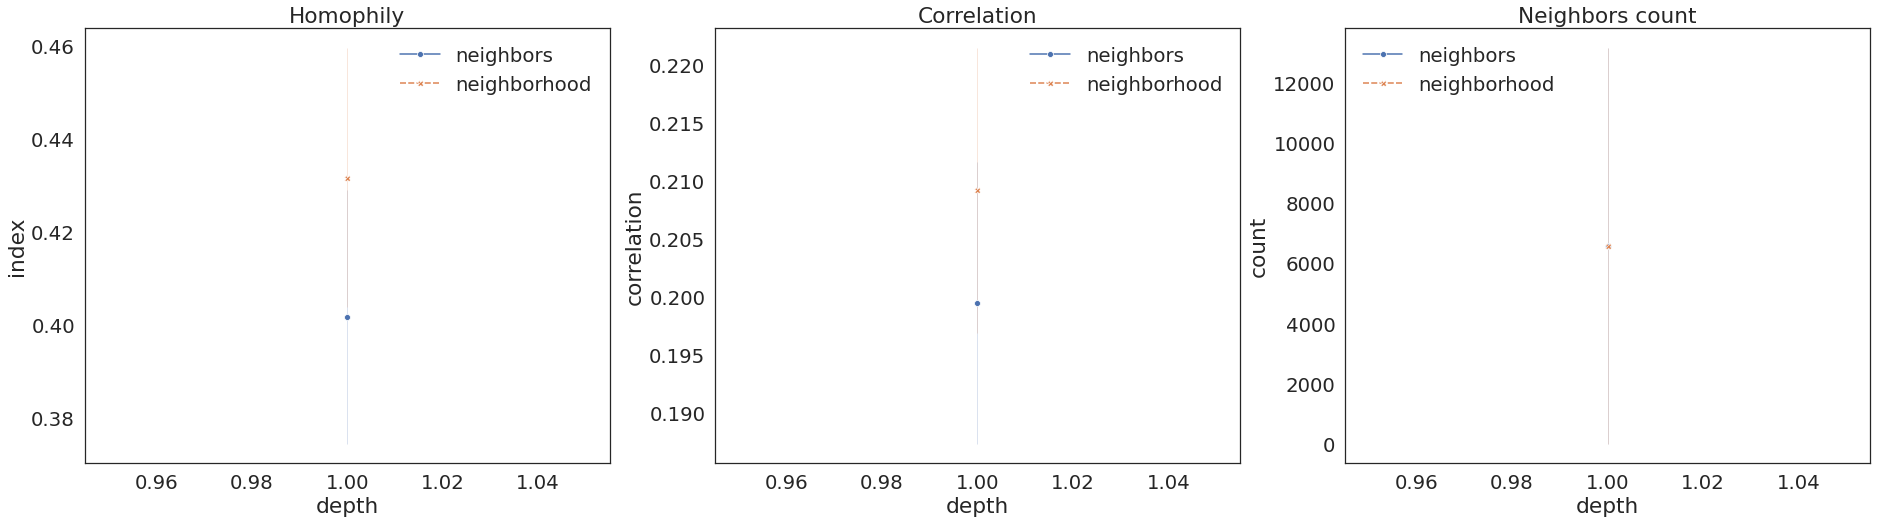

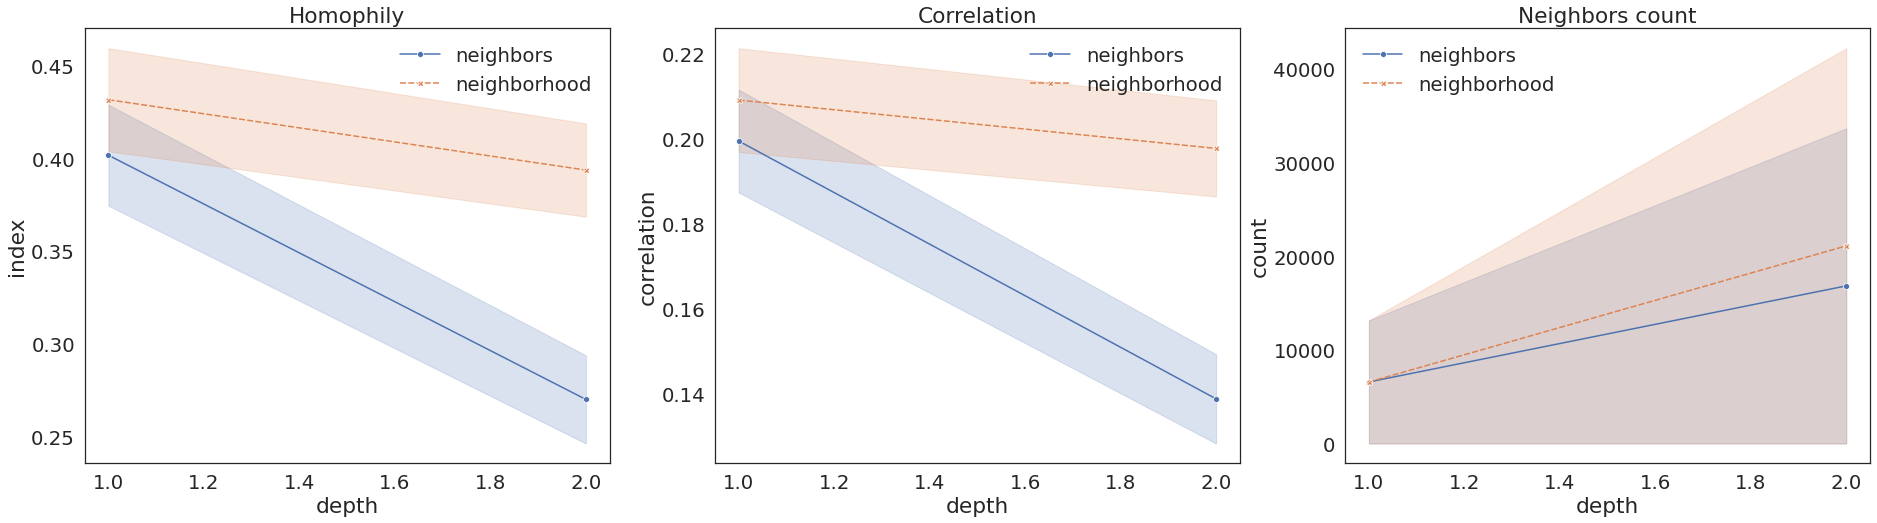

In [18]:
summary = graph_summary([data], K=10) # diameter: 23
summary.to_csv("./ogbn_arxiv_summary.csv", index=False)
plot_summary(summary)